# MLP Classifier

### Importing some libraries we will use

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from helper_fun import *
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


### Importing our data and the different splits we have created

In [3]:
# Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

Check our data is of the right size

In [4]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((8000, 13), (8000,), (2000, 13), (2000,))

Import the 4 different splits we have created from the train_raw which we will use to build the model to then do a final test on test_raw with the hope recreating a competition scenario

In [5]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

These are the splits we have

In [6]:
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

## Creating our initial model

For our initial model we will use a fairly standard neural network design, with 2 hidden layers, one with 32 nodes the next with 16. We only have 13 features so I didn't want the model to be too complicated and I was also wary of the model taking too long to train on my laptop. This didn't prove too much of an issue apart from hyper-parameter tuning which we will get to later.

In [7]:
# Define the model
model = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

In helper_fun we have created a function that will help us evaluate the performance of our different splits using a variety of different metrics.

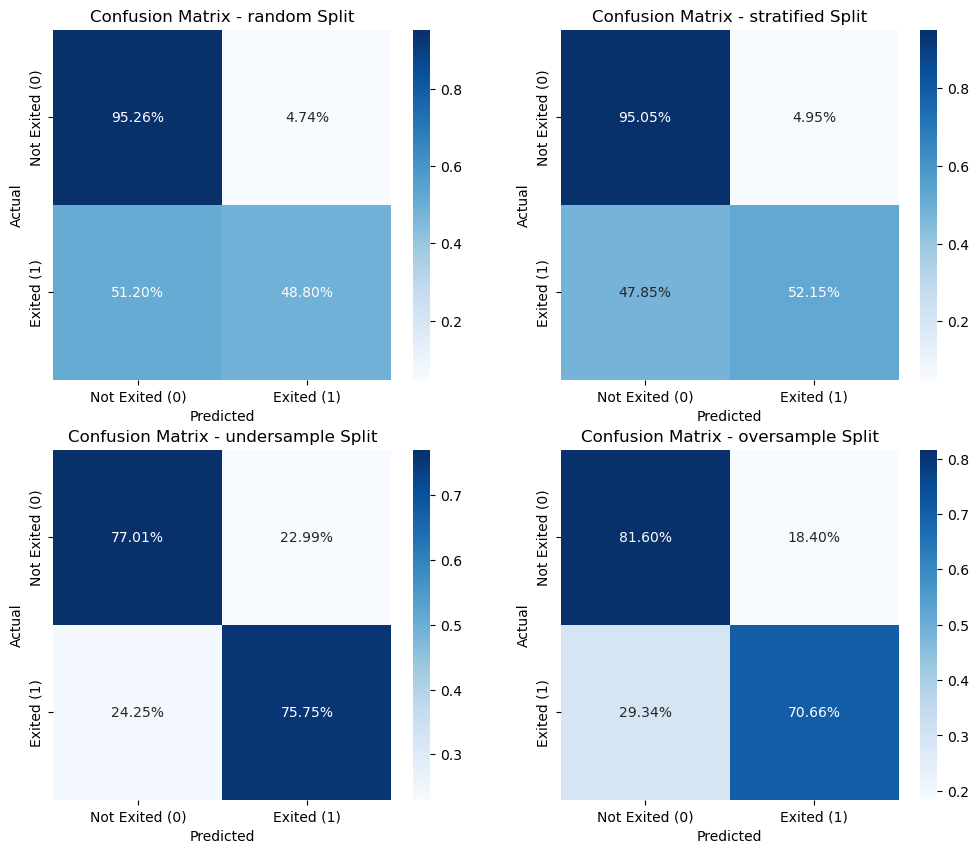

<Figure size 800x600 with 0 Axes>

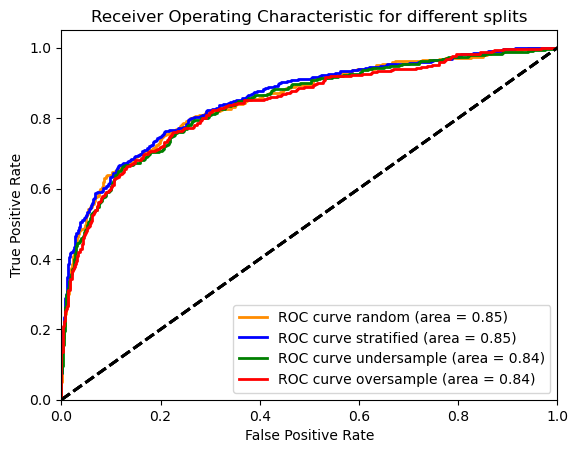

In [8]:
performance_df = evaluating_performance_diff_splits(model, split_data, key_metric_only=True)  

The ROC curves indicate a fairly good performance on all four of our splits, the confusion matrices give a less convincing story, lets take a look at the rest of the metrics before we comment further.

In [9]:
performance_df

,recall,f1-score,balalanced_MCC
random,0.488024,0.585278,0.497590
stratified,0.521472,0.608229,0.522571
undersample,0.757485,0.576310,0.527669
oversample,0.706587,0.587796,0.525696


Looking at our recall we can see when trained on the random split it is extremely low at 0.48 and 0.52 on stratified this is likely due to our imbalanced data and it not seeing a lot of positive (churns) in training. We can also see this in our confusion matrices, we want the bottom left to be as light as possible, we see undersampling is performing best here. In our situation having a higher recall is important as we don't want to lose customers, we would rather have a lower precision and higher recall, which we see when trained on our undersampled and oversampled. We can also see from the heatmap that undersampling is giving us a lower percentage in the bottom left which is what we want.

## Parameter tuning

Before we proceed further I want to see if I can get a little bit more performance out of the model by picking better parameters, I won't spend too much time doing this now though and will simply use a random search with 5 fold cross validation to see if we can find better parameters for a 2 layer NN.

I will look to maximise the f1_score as I belive this is a good metric to indicate a good overal performance on our imbalanced data. I will perfom the tuning on the whole of the X_train_raw and y_train_raw.

In [10]:
# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)

In [10]:
# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(randint(3, 128).rvs(), randint(3, 128).rvs())],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=1, random_state=42)

# Fit the random search to the data
random_search.fit(X_train_raw, y_train_raw)
print("Done")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

Select the best parameters and define a new model with these parameters.

In [ ]:
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_
print(f"Best parameters: {best_params_random}"+f"\nBest score: {best_score_random}")

In [13]:
model_RS = MLPClassifier(**best_params_random, max_iter=1000, random_state=42)

Look at our 3 important metrics for our model with new parameters.

In [14]:
performance_RS_df = evaluating_performance_diff_splits(model_RS, split_data,display_confusion=False,display_roc=False, key_metric_only=True)

In [ ]:
performance_RS_df

In terms of recall this is making all of the splits worse apart from stratified which shows a bit of an increase in performance. The f1-score performance also varies a bit from the original model. I'm not sure if these metrics are really much of an improvment but I will proceed with this new model for now.

### SHAP for feature importance

https://github.com/slundberg/shap

Shap uses a game theory approach to see how important each feature is, it captures the importance of each feature by comparing what a model predicts with and without this feature. As the order the model sees a feature also affects performance, removing the feature is done in all possible ways so it is fair for all features.

In [ ]:
!pip install shap

### Feature Importance

Here we try and remove some features that the model my deem as not as important to predicting the churning. Doing this could help reduce overfitting and eliminate noise.

We use permutation feature importance, this shows the affect of the models performance if a feature was randomly reorganised between each observation.

In [ ]:
from sklearn.inspection import permutation_importance

X_train_random, X_val_random, y_train_random, y_val_random = split_data['random']
model_RS.fit(X_train_random, y_train_random)
# Calculate permutation importance
perm_importance = permutation_importance(model_RS, X_val_random, y_val_random, n_repeats=500, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test_raw.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Take top 11 as they all improve performance according to the feature importance.

In [ ]:
top_11_features = feature_importance_df.head(11)
top_11_feature_indices = [X_test_raw.columns.get_loc(feature) for feature in top_11_features['Feature']]
print(top_11_feature_indices)

In [ ]:
# Filter the splits to retain only the top 5 features
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    split_data[split] = (
        X_train.iloc[:, top_11_feature_indices],
        X_val.iloc[:, top_11_feature_indices],
        y_train,
        y_val
    )

# Verify the changes
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    print(f"{split} split - X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

In [55]:
performance_RS_df_top11 = evaluating_performance_diff_splits(model, split_data, display_confusion=False, display_roc=False, key_metric_only=True)

In [ ]:
performance_RS_df_top11

Compare to our original metrics from original model and data splits

In [ ]:
performance_df

So we have worse recall in all cases, but apart from the random split we see an improvement in f1-score and balanced MCC. Recall is probably getting worse as we must have removed a feature that is important for predicting churning but not staying with the bank, and as our dataset is imbalanced the permutation importance has deemed it not important.

I don't think it is worth removing any features for this as most features are deemed important. I also don't like the idea of removing credit score even though it is saying it isn't important for a churn I think it would be.

Go back to our original split.

In [13]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

To irradicate some of the issues above I'm gonna try do the same thing but on the undersampled split and see what I get.

In [14]:
from sklearn.inspection import permutation_importance

X_train_under, X_val_under, y_train_under, y_val_under = split_data['undersample']
model_RS.fit(X_train_under, y_train_under)
# Calculate permutation importance
perm_importance = permutation_importance(model_RS, X_val_under, y_val_under, n_repeats=500, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test_raw.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

NameError: name 'model_RS' is not defined

This implies all features help improve performance.

Now look at which features help improve recall of positive class.

In [15]:
recall_scorer = make_scorer(recall_score, pos_label=1)

In [ ]:
from sklearn.inspection import permutation_importance

X_train_under, X_val_under, y_train_under, y_val_under = split_data['undersample']
model_RS.fit(X_train_under, y_train_under)
# Calculate permutation importance
perm_importance = permutation_importance(model_RS, X_val_under, y_val_under,scoring=recall_scorer, n_repeats=500, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test_raw.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Again a lot that improve performance but there seem to be some more standout ones here.

In [ ]:
top_5_features = feature_importance_df.head(5)
top_5_feature_indices = [X_test_raw.columns.get_loc(feature) for feature in top_5_features['Feature']]
print(top_5_feature_indices)

In [ ]:
# Filter the splits to retain only the top 5 features
split_data_5={}
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    split_data_5[split] = (
        X_train.iloc[:, top_5_feature_indices],
        X_val.iloc[:, top_5_feature_indices],
        y_train,
        y_val
    )

# Verify the changes
for split in split_data_5:
    X_train, X_val, y_train, y_val = split_data_5[split]
    print(f"{split} split - X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

In [72]:
performance_RS_df_top5 = evaluating_performance_diff_splits(model_RS, split_data_5, display_confusion=False, display_roc=False, key_metric_only=True)

In [ ]:
performance_RS_df_top5

This has helped improve recall on oversampling quite considerably.

### 2D representation of our data

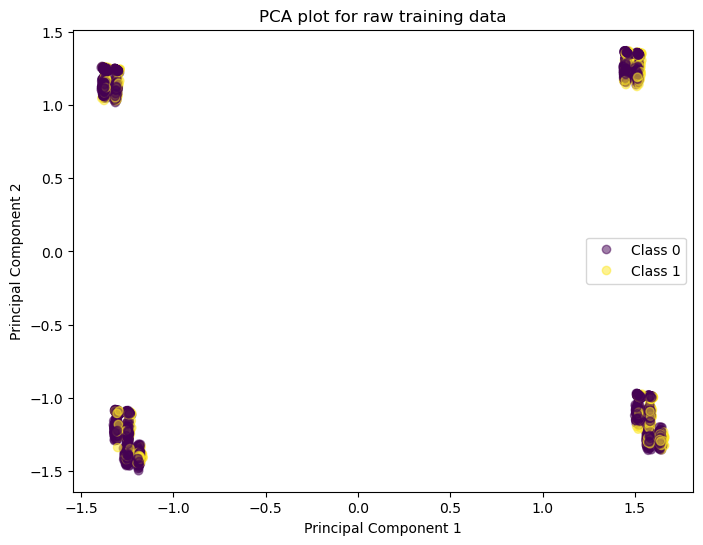

In [16]:
from sklearn.decomposition import PCA
X_train_random, X_val_random, y_train_random, y_val_random = split_data['random']
# Function to plot PCA
def plot_pca_2d(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
    plt.show()

plot_pca_2d(X_train_random, y_train_random, 'PCA plot for raw training data')

So far my best perfromance seems to be coming from when I am training using a balanced dataset this is giving me the best chance of having a higher recall.

When I train my final model I don't want to lose as much data as I do from undersampling or risk the chance of overfitting that comes from duplicating observations like we do in oversampling. So here I'm going to try a combination of SMOTE to oversample and at the same time undersample my majority class.

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy=0.35) #oversamples to make minority class 30%
under = RandomUnderSampler(sampling_strategy=0.5) #undersamples to make majority class 50%
X_resampled, y_resampled = over.fit_resample(X_train_random, y_train_random)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)
print(f"Resampled X shape: {X_resampled.shape}")
print(f"Resampled y shape: {y_resampled.shape}")

Resampled X shape: (5358, 13)
Resampled y shape: (5358,)


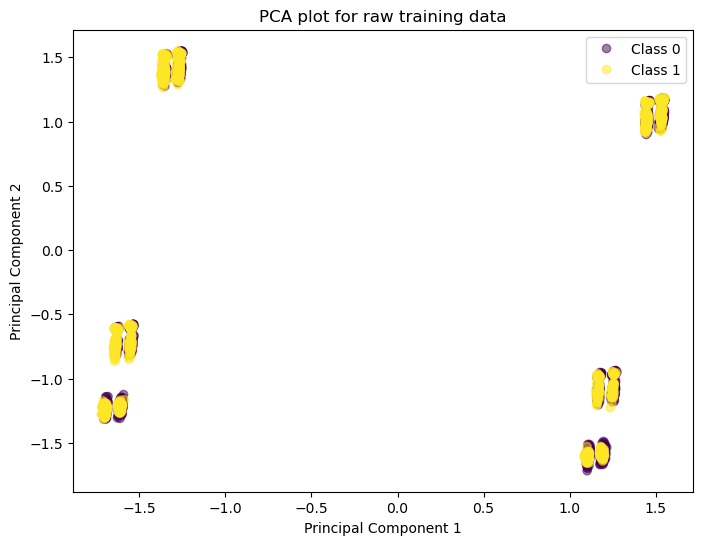

In [18]:
plot_pca_2d(X_resampled, y_resampled, 'PCA plot for raw training data')

In [20]:
smote_under_split = {'SMOTE_under': (X_resampled, X_val_random, y_resampled, y_val_random)}
performance_SMOTE_under_df = evaluating_performance_diff_splits(model, smote_under_split, display_confusion=False, display_roc=False, key_metric_only=True)

In [21]:
performance_SMOTE_under_df

,recall,f1-score,balalanced_MCC
SMOTE_under,0.640719,0.623907,0.549192


This doesn't seem to have improved the performance of the model. It is offering similar to just using a radnom split.

### Optuna

I'm gonna try improve my model parameters again but this time using optuna.

In [11]:
!pip install optuna

In [18]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_units_layer1 = trial.suggest_int('n_units_layer1', 10, 200)
    n_units_layer2 = trial.suggest_int('n_units_layer2', 10, 200)   
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1,log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    
    hidden_layer_sizes = (n_units_layer1, n_units_layer2)
    # Create the model with suggested hyperparameters
    model_optuna = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=1000,
        random_state=42
    )
    
    # Evaluate the model using cross-validation
    score = cross_val_score(model_optuna, X_train_raw, y_train_raw, cv=5, scoring=f1_scorer).mean()
    
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

study.optimize(objective, timeout=120)

# Get the best parameters and score
best_params_optuna = study.best_params
best_score_optuna = study.best_value
print(f"Best parameters: {best_params_optuna}")
print(f"Best score: {best_score_optuna}")

[I 2024-10-25 23:04:31,374] A new study created in memory with name: no-name-90073a40-f0df-4559-9d8f-3c22cea66db3
[I 2024-10-25 23:06:22,476] Trial 0 finished with value: 0.5724655287643133 and parameters: {'n_units_layer1': 81, 'n_units_layer2': 191, 'activation': 'relu', 'solver': 'adam', 'alpha': 1.7073967431528103e-05, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.5724655287643133.
[I 2024-10-25 23:06:57,196] Trial 1 finished with value: 0.5927890277231784 and parameters: {'n_units_layer1': 145, 'n_units_layer2': 13, 'activation': 'relu', 'solver': 'adam', 'alpha': 5.415244119402538e-05, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.5927890277231784.
[I 2024-10-25 23:08:10,288] Trial 2 finished with value: 0.5585200701855937 and parameters: {'n_units_layer1': 92, 'n_units_layer2': 65, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0006672367170464204, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.5927890277231784.
[I 2024-10-25 23:08:34,

Best parameters: {'n_units_layer1': 85, 'n_units_layer2': 38, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021121340425575865, 'learning_rate': 'adaptive'}
Best score: 0.6058285910201333


In [37]:
import pickle

# Save the study object to a pickle file
with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [36]:
import optuna

# Load the study object from the pickle file
with open('optuna_study.pkl', 'rb') as f:
    study = pickle.load(f)

# Resume the optimization process
study.optimize(objective, n_trials=75, timeout=3600)

# Get the best parameters and score after resuming
best_params_optuna = study.best_params
best_score_optuna = study.best_value
print(f"Best parameters after resuming: {best_params_optuna}")
print(f"Best score after resuming: {best_score_optuna}")

[I 2024-10-26 16:16:51,399] Trial 220 finished with value: 0.5717887686514029 and parameters: {'n_units_layer1': 136, 'n_units_layer2': 187, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.003446147673823436, 'learning_rate': 'adaptive'}. Best is trial 81 with value: 0.6058285910201333.
[I 2024-10-26 16:17:21,822] Trial 221 finished with value: 0.5998404368371681 and parameters: {'n_units_layer1': 69, 'n_units_layer2': 41, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00826883054789533, 'learning_rate': 'adaptive'}. Best is trial 81 with value: 0.6058285910201333.
[I 2024-10-26 16:17:49,709] Trial 222 finished with value: 0.5847526081038827 and parameters: {'n_units_layer1': 58, 'n_units_layer2': 45, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006051495049079837, 'learning_rate': 'adaptive'}. Best is trial 81 with value: 0.6058285910201333.
[I 2024-10-26 16:18:14,630] Trial 223 finished with value: 0.5848640706288762 and parameters: {'n_units_layer1': 65, 'n_units_layer2'

Best parameters after resuming: {'n_units_layer1': 85, 'n_units_layer2': 38, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021121340425575865, 'learning_rate': 'adaptive'}
Best score after resuming: 0.6058285910201333


In [28]:
best_params = study.best_params
hidden_layer_sizes = (best_params['n_units_layer1'], best_params['n_units_layer2'])
best_params['hidden_layer_sizes'] = hidden_layer_sizes
del best_params['n_units_layer1']
del best_params['n_units_layer2']

print(f"Best hyperparameters: {best_params}")



Best hyperparameters: {'activation': 'relu', 'solver': 'adam', 'alpha': 0.021121340425575865, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (85, 38)}


In [22]:
# Define a new model with the best parameters
model_optuna = MLPClassifier(**best_params, max_iter=1000, random_state=42)

In [39]:
model_optuna

MLPClassifier(alpha=0.021121340425575865, hidden_layer_sizes=(85, 38),
              learning_rate='adaptive', max_iter=1000, random_state=42)

In [24]:
performance_optuna = evaluating_performance_diff_splits(model_optuna, split_data, display_confusion=False, display_roc=False, key_metric_only=True)

In [26]:
performance_optuna

,recall,f1-score,balalanced_MCC
random,0.467066,0.583178,0.497415
stratified,0.503067,0.602941,0.517199
undersample,0.751497,0.583721,0.534539
oversample,0.667665,0.579221,0.506281


## Probability threshold

Our main issue is clearly a lower recall than we would like for the positive class, to try to increase this I'm gonna try adjust the probability threshold in a way to increase our recall but not sacrifice too much precision. I will do this using the ROC curve and choose the threshold that corresponds to the point closest to the top left, which will give us a high sensitivity, while keeping specicivity at an appropriate level hopefully.

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

I'm gonna work with the model parameters I've got from optuna even though right now the metrics don't look as good as the initial model, but as the parameters were chosen using k-fold cross-validation my thinking is that they will generalise better to the unseen data. I will also start off by just focusing on doing this for the stratified split.

In [38]:
X_train_strat, X_val_strat, y_train_strat, y_val_strat = split_data['stratified']

In [42]:
model_optuna.fit(X_train_strat, y_train_strat)
y_prob = model_optuna.predict_proba(X_val_strat)[:, 1]

As detailed in the blog post above, we can find this optimal threshold using Youden's J statistic

J = Sensitivity + Specisivity - 1

Which is equivalent to

J = TPR - FPR

We will look for the threshold that maximises J.

In [45]:
fpr, tpr, thresholds = roc_curve(y_val_strat, y_prob)
threshold_05_index = np.where(thresholds <= 0.5)[0][0]
print(f"Index for threshold 0.5: {threshold_05_index}")
J= tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print(f"Best threshold: {best_threshold}")

Index for threshold 0.5: 71
Best threshold: 0.25520605596780466


This threshold is considerably lower than the standard 0.5, lets also visulaise this on the ROC curve.

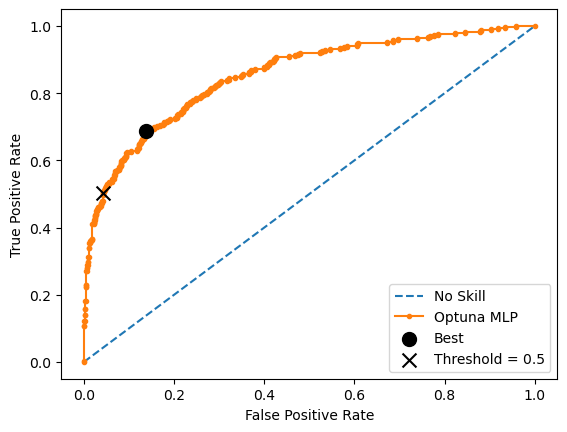

In [56]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Optuna MLP')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100,zorder=5)
plt.scatter(fpr[threshold_05_index], tpr[threshold_05_index], marker='x', color='black', label='Threshold = 0.5', s=100, zorder=5)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()


Now let's look at the performance metrics using this threshold on our stratified split.

In [47]:
y_val_pred = (y_prob> best_threshold).astype(int)

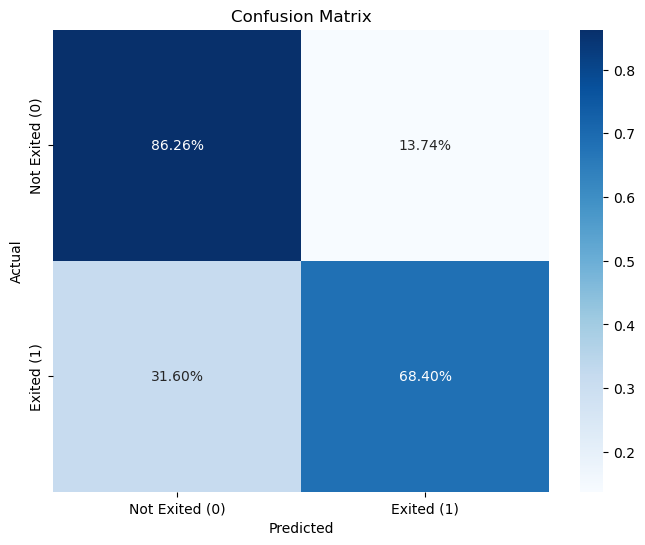

,recall,f1-score,balalanced_MCC
Raw split,0.684049,0.616022,0.555619


In [50]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val_strat, y_val_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate classification report
report = classification_report(y_val_strat, y_val_pred)
# Extract metrics from classification report
report_dict = classification_report(y_val_strat, y_val_pred, output_dict=True)
balanced_MCC = balanced_MCC_macro_avg(y_val_strat, y_val_pred)

performance_best_thresh = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }

performance_best_thresh_df = pd.DataFrame(performance_best_thresh, index=['Raw split'])
performance_best_thresh_df


These metrics are much more encouraging, the balanced MCC is still not maybe as high as you would like, but our recall is improved from 0.52 initially to 0.68 and we are keeping our false positives low enough to avoid wasting too many resources. It is also a positive that we are getting good results on a stratified split as this should gneralise well to unseen data as both the training and validation sets maintain the class distribution of our seen data, so it should provide a representitive evaluation of the models performance, 

## Bagging

To further imrpove the generalization of my model I'm going to perform bagging, this will help reduce the variance of my predictions and is also a good ensemble method to use with imbalanced data.

I will perform bagging on my MLP classifier with the parameters from optuna and then similar to above will adjust the probability threshold afterwards.

In [60]:
from sklearn.ensemble import BaggingClassifier

# Initialize the BaggingClassifier with the model_optuna
bagging_model = BaggingClassifier(estimator=model_optuna, n_estimators=50, random_state=42, n_jobs=-1)

# Fit the bagging model on the stratified training data
bagging_model.fit(X_train_strat, y_train_strat)

y_prob_bag = bagging_model.predict_proba(X_val_strat)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_strat, y_prob_bag)
J= tpr - fpr
ix = np.argmax(J)
best_threshold_bag = thresholds[ix]

y_val_pred_bag = (y_prob_bag> best_threshold_bag).astype(int)

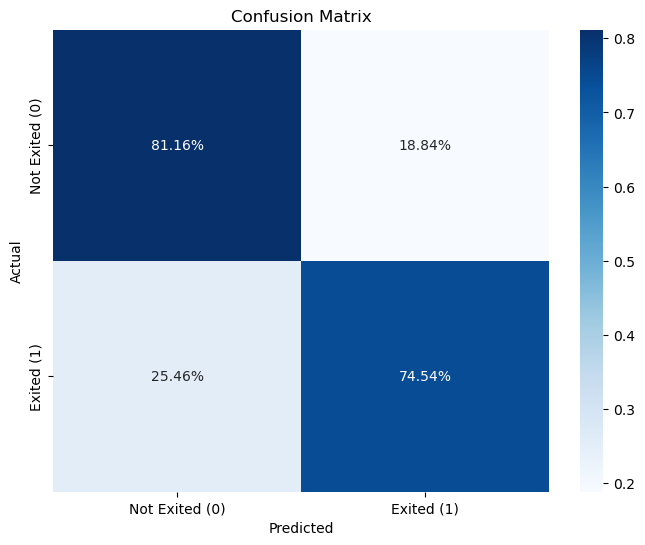

,recall,f1-score,balalanced_MCC
Raw split,0.745399,0.600742,0.558241


In [61]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val_strat, y_val_pred_bag)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate classification report
report = classification_report(y_val_strat, y_val_pred_bag)
# Extract metrics from classification report
report_dict = classification_report(y_val_strat, y_val_pred_bag, output_dict=True)
balanced_MCC = balanced_MCC_macro_avg(y_val_strat, y_val_pred_bag)

performance_bagging = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }

performance_bagging_df = pd.DataFrame(performance_bagging, index=['Raw split'])
performance_bagging_df